<a href="https://colab.research.google.com/github/MarisaRies/covir/blob/main/COVIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
#Encryption
#!pip install cape_privacy

In [112]:
################
#Datenbankaufbau
################

#Lade Bibliotheken
import sqlite3            as sq
from sqlite3 import Error
import pandas             as pd
import numpy              as np
import requests
import datetime           as dt
import seaborn            as sns
import matplotlib.pyplot  as plt
import matplotlib         as mpl
%matplotlib inline

#Pfad Definitionen
drive_path        = "/content/drive"
project_root_path = f"{drive_path}/MyDrive/Studium/COVIR"
csv_file_path     = f"{project_root_path}/CSV/"
image_path        = f"{project_root_path}/Bilder/"

#Verbinden von GDrive
from google.colab import drive 
drive.mount("/content/drive", force_remount=True)

#Verbindung zu SQLite
def create_connection_memory():
  conn = None;
  try:
    #Verbindungsaufbau
    conn = sq.connect(':memory:')
    return conn
    print(sqlite3.version)
  except Error as e:
    print("Datenbank: Fehler #1 beim Verbinden zu SQLite", e)

#Lokale Definition der SQLite Verbindung
def create_connection_local(local_path):
  conn = None;
  try:
    #Verbindungsaufbau
    conn = sq.connect(local_path+'/Studium/covir.db')
    return conn
    print(sqlite3.version)
  except Error as e:
    print("Datenbank: Fehler #2 beim Verbinden zu SQLite", e) 
conn = create_connection_memory()

cur = conn.cursor()
print("Datenbank: Verbindung erfolgreich zu SQLite")

#Tabellenschema erzeugen
cur.executescript(requests.get('https://raw.githubusercontent.com/MarisaRies/covir/main/sql/db_create_statements.sql').text)

#Erstelle zentrale View für das Stern-Schema
cur.executescript(requests.get('https://raw.githubusercontent.com/MarisaRies/covir/main/sql/ETLview_create_statement.sql').text)

conn.commit()
print("Datenbank: Tabellenschema erfolgreich erstellt")



Mounted at /content/drive
Datenbank: Verbindung erfolgreich zu SQLite
Datenbank: Tabellenschema erfolgreich erstellt


In [113]:
# ETL-Prozess
#
# Extraktion
#

#CSV-Daten aus Google-Drive laden, relevante Spalten auswählen und in Datenbank laden
df_insert_pat = pd.read_csv(csv_file_path+'patients.csv')
df_insert_pat = df_insert_pat[['Id','BIRTHDATE','DEATHDATE','FIRST','LAST']]

df_insert_enc = pd.read_csv(csv_file_path+'encounters.csv')
df_insert_enc = df_insert_enc[['Id','START','STOP','PATIENT','CODE','DESCRIPTION']]

df_insert_con = pd.read_csv(csv_file_path+'conditions.csv')
df_insert_con = df_insert_con[['ENCOUNTER','START','STOP','PATIENT','CODE','DESCRIPTION']]

df_insert_imm = pd.read_csv(csv_file_path+'immunizations.csv')
df_insert_imm = df_insert_imm[['ENCOUNTER','DATE','PATIENT','CODE','DESCRIPTION']]

print("ETL-Extraktion:     Relevante Daten aus Quelldatenbank extrahiert")

#
# Transformation
#

#Alter berechnen und als neues Feld der Patienten-Tabelle hinzufügen
df_insert_pat['BIRTHDATE'] = pd.to_datetime(df_insert_pat['BIRTHDATE'], format='%Y-%m-%d') #Daten von String in DateTime umwandeln für spätere Berechnung
df_insert_pat['DEATHDATE'] = pd.to_datetime(df_insert_pat['DEATHDATE'], format='%Y-%m-%d')

df_insert_pat['EOL'] = df_insert_pat.DEATHDATE #Temporäre Spalte für Referenzpunkt der Altersberechnung (Todestag oder Heute)
df_insert_pat['EOL'] = df_insert_pat['EOL'].fillna(pd.to_datetime("today")) #Einsetzen von heutigem Datum, falls kein Todestag bekannt

df_insert_pat['AGE'] =  df_insert_pat['EOL'].dt.year - df_insert_pat['BIRTHDATE'].dt.year #Alter berechnen (Referenztag - Geburtstag) und in neue Spalte 'AGE' einfügen
df_insert_pat = df_insert_pat.drop(columns=['EOL']) #Temporäre Spalte wieder löschen

print("ETL-Transformation: Alter berechnet und in Patienten-Tabelle eingefügt")

#
# Laden
#

df_insert_pat.to_sql('tb_patients', conn, if_exists='append', index=False)
df_insert_enc.to_sql('tb_encounters', conn, if_exists='append', index=False)
df_insert_con.to_sql('tb_conditions', conn, if_exists='append', index=False)
df_insert_imm.to_sql('tb_immunizations', conn, if_exists='append', index=False)

conn.commit()

print("ETL-Laden:          CSV-Daten erfolgreich geladen, Datenbank bereit")

ETL-Extraktion:     Relevante Daten aus Quelldatenbank extrahiert
ETL-Transformation: Alter berechnet und in Patienten-Tabelle eingefügt
ETL-Laden:          CSV-Daten erfolgreich geladen, Datenbank bereit


In [114]:
#Übersicht Patienten Tabelle
df_patients = pd.read_sql_query("SELECT * FROM tb_patients", conn)
df_patients.info()
df_patients

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1050 non-null   object
 1   birthdate  1050 non-null   object
 2   deathdate  50 non-null     object
 3   age        1050 non-null   int64 
 4   first      1050 non-null   object
 5   last       1050 non-null   object
dtypes: int64(1), object(5)
memory usage: 49.3+ KB


,id,birthdate,deathdate,age,first,last
0,2f114e21-8b95-e9eb-2e9e-4b950b059cfa,2002-05-05 00:00:00,None,20,Terisa250,Kreiger457
1,2812f4fc-6aba-0033-728b-7e569bb8adcc,1942-05-24 00:00:00,None,80,Romeo514,Morar593
2,9b1a203a-6368-49a5-0c79-45c32729bc17,2013-06-15 00:00:00,None,9,Jamaal34,Hessel84
3,52a250a9-24e4-ec9b-91d6-c38cf1b10fc0,1997-11-16 00:00:00,None,25,Kenya524,Leuschke194
4,ad5525c0-fdab-94dc-018f-d7209c72bdef,1965-08-28 00:00:00,None,57,Clark193,Little434
...,...,...,...,...,...,...
1045,edab2899-dac4-a19d-59e2-a9bea7b95cab,1999-08-12 00:00:00,None,23,Tricia672,Buckridge80
1046,d1065043-2a5f-2d0e-1dd0-cb7f31e6d340,1960-04-30 00:00:00,None,62,Carla633,Centeno914
1047,4c523ab1-3255-911a-7eef-3bc3e48b7b05,1961-11-11 00:00:00,None,61,Simon598,Schimmel440
1048,8d49cb05-b1c3-b8fe-dc75-e43ad861f074,1920-02-27 00:00:00,2020-03-28 00:00:00,100,Luella739,Schmidt332


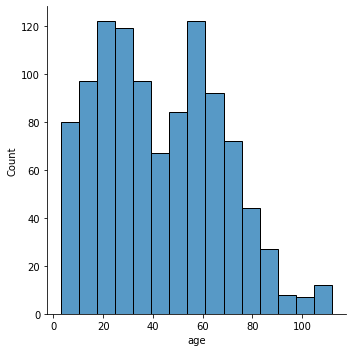

In [115]:
#Grafik Altersverteilung
sns.displot(df_patients["age"])
plt.savefig(image_path+'Histogramm_Patientenalter.png')
plt.show()

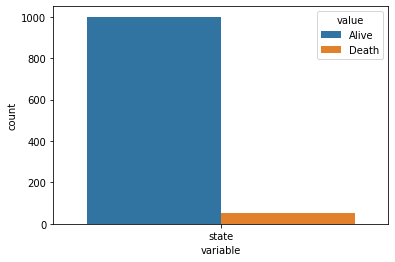

In [116]:
#Grafik Alive vs Death
df_patients["state"] = df_patients["deathdate"]
df_patients["state"] = df_patients["state"].fillna('Alive') #Normalisierung von NaN nach 'Alive'
df_patients["state"] = df_patients["state"].replace(['[^Alive]'], '', regex = True) #Normalisierung jeder Zeile ungleich 'Alive' nach '' mittels regulärem Ausdruck
df_patients["state"] = df_patients["state"].replace([''], 'Death') #Ersetzen von '' mit 'Death'

sns.countplot(x="variable", hue= "value", data=pd.melt(df_patients[["state"]]))
plt.savefig(image_path+'Histogramm_Lebendig-Tot.png')
plt.show()

In [117]:
#Übersicht Encounter (Begegnung) Tabelle
df_encounter = pd.read_sql_query("SELECT * FROM tb_encounters", conn)
df_encounter.info()
df_encounter

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9802 non-null   object
 1   start        9802 non-null   object
 2   stop         9802 non-null   object
 3   patient      9802 non-null   object
 4   code         9802 non-null   object
 5   description  9802 non-null   object
dtypes: object(6)
memory usage: 459.6+ KB


,id,start,stop,patient,code,description
0,7627d701-6c75-be69-0fcc-aeb32ea27270,2013-10-21T09:22:47Z,2013-10-21T09:37:47Z,f7dddcba-380e-7fd4-20b0-da086ce5dc3a,162673000,General examination of patient (procedure)
1,e0361112-89b9-9057-f577-ce5878f47f86,2011-09-17T21:57:21Z,2011-09-17T22:12:21Z,ad5525c0-fdab-94dc-018f-d7209c72bdef,162673000,General examination of patient (procedure)
2,2891a0e4-ee92-6a31-c4e4-5de8cedddf19,2011-09-11T17:40:13Z,2011-09-11T17:55:13Z,2812f4fc-6aba-0033-728b-7e569bb8adcc,162673000,General examination of patient (procedure)
3,a736e521-64e7-fe9c-6261-8776b3ab3d76,2012-02-24T15:16:17Z,2012-02-24T15:31:17Z,7f30313f-98e9-2cc2-68a5-6f9973f9ad5a,162673000,General examination of patient (procedure)
4,1f7153da-bb06-0645-7e15-1f82cff08975,2014-12-12T15:16:17Z,2014-12-12T15:31:17Z,7f30313f-98e9-2cc2-68a5-6f9973f9ad5a,162673000,General examination of patient (procedure)
...,...,...,...,...,...,...
9797,0e0f8b58-fc48-4d52-e8f8-f465f9b4e9fd,2015-11-13T06:00:19Z,2015-11-13T06:15:19Z,fce5ed5c-e218-4839-a0c5-6ef906e5ae73,162673000,General examination of patient (procedure)
9798,9697db80-f51c-e97e-dbbe-9bb3ddc97c9a,2016-11-18T06:00:19Z,2016-11-18T06:15:19Z,fce5ed5c-e218-4839-a0c5-6ef906e5ae73,162673000,General examination of patient (procedure)
9799,c612781e-2a9a-001e-e570-0bb13235bb58,2017-11-24T06:00:19Z,2017-11-24T06:15:19Z,fce5ed5c-e218-4839-a0c5-6ef906e5ae73,162673000,General examination of patient (procedure)
9800,ecb6cf1b-2c6f-b09e-4319-fc3376c85724,2018-11-30T06:00:19Z,2018-11-30T06:15:19Z,fce5ed5c-e218-4839-a0c5-6ef906e5ae73,162673000,General examination of patient (procedure)


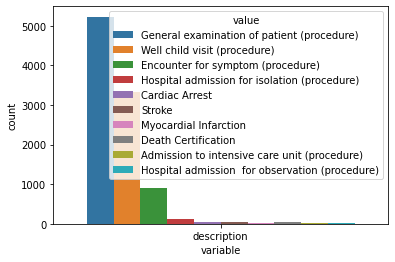

In [125]:
#Grafik Verteilung der Begenungsgründe
sns.countplot(x="variable", hue= "value", data=pd.melt(df_encounter[["description"]]))
plt.savefig(image_path+'Histogramm_Begegnungsgrund.png')
plt.show()

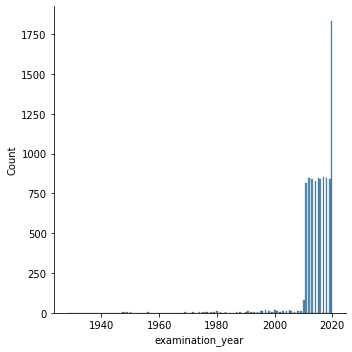

In [131]:
#Grafik zeitliche Verteilung der Begnungen (Jahr)
df_encounter["examination_year"] = pd.DatetimeIndex(df_encounter['start']).year #Normalisierung auf Jahr, um Plot zu verbessern
sns.displot(df_encounter["examination_year"])
plt.savefig(image_path+'Histogramm_Begegnungsverteilung.png')
plt.show()

In [ ]:
#Grafik zeitliche Verteilung der Begegnungen (2019-2021, monatlich)
#todo

In [132]:
#Übersicht Condition (Symptome) Tabelle
df_condition = pd.read_sql_query("SELECT * FROM tb_conditions", conn)
df_condition.info()
df_condition

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6375 entries, 0 to 6374
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   encounter    6375 non-null   object
 1   start        6375 non-null   object
 2   stop         5474 non-null   object
 3   patient      6375 non-null   object
 4   code         6375 non-null   object
 5   description  6375 non-null   object
dtypes: object(6)
memory usage: 299.0+ KB


,encounter,start,stop,patient,code,description
0,1d453a83-17f7-490d-5576-09f5725cdcaa,2020-02-17,2020-02-27,ad5525c0-fdab-94dc-018f-d7209c72bdef,49727002,Cough (finding)
1,ccb50c60-5c51-3d03-3aeb-824325cfac91,2020-02-24,2020-03-11,7f30313f-98e9-2cc2-68a5-6f9973f9ad5a,49727002,Cough (finding)
2,1d453a83-17f7-490d-5576-09f5725cdcaa,2020-02-17,2020-02-27,ad5525c0-fdab-94dc-018f-d7209c72bdef,386661006,Fever (finding)
3,1d453a83-17f7-490d-5576-09f5725cdcaa,2020-02-17,2020-02-27,ad5525c0-fdab-94dc-018f-d7209c72bdef,36955009,Loss of taste (finding)
4,1d453a83-17f7-490d-5576-09f5725cdcaa,2020-02-17,2020-02-17,ad5525c0-fdab-94dc-018f-d7209c72bdef,840544004,Suspected COVID-19
...,...,...,...,...,...,...
6370,d9a1e5b3-0023-3f46-c694-7c91871b3c3d,2020-03-25,None,8d49cb05-b1c3-b8fe-dc75-e43ad861f074,86175003,Injury of heart (disorder)
6371,d9a1e5b3-0023-3f46-c694-7c91871b3c3d,2020-03-25,None,8d49cb05-b1c3-b8fe-dc75-e43ad861f074,84114007,Heart failure (disorder)
6372,d9a1e5b3-0023-3f46-c694-7c91871b3c3d,2020-03-25,None,8d49cb05-b1c3-b8fe-dc75-e43ad861f074,67782005,Acute respiratory distress syndrome (disorder)
6373,7afafba9-d516-51e7-78e4-51b99534bf1c,1991-09-20,None,fce5ed5c-e218-4839-a0c5-6ef906e5ae73,230690007,Stroke


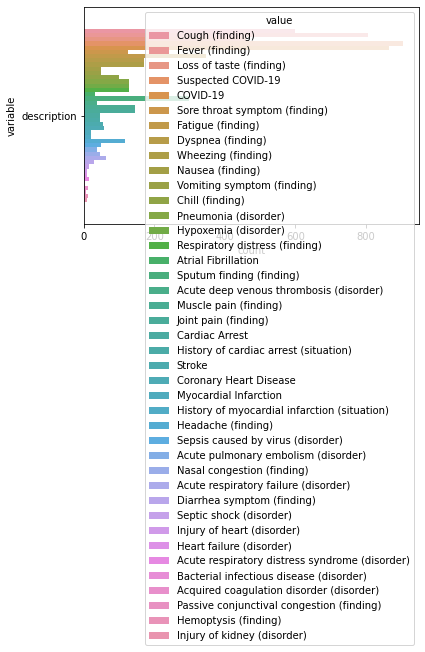

In [143]:
#Grafik Verteilung der Symptome
sns.countplot(y="variable", hue= "value", data=pd.melt(df_condition[["description"]]))
plt.savefig(image_path+'Histogramm_Symptomverteilung.png')
plt.show()

In [ ]:
#Grafik Anzahl Symptome pro Patient (gestaffelt)

In [135]:
#Übersicht Immunisierung (Impfungen) Tabelle
df_immunization = pd.read_sql_query("SELECT * FROM tb_immunizations", conn)
df_immunization.info()
df_immunization

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   encounter    13125 non-null  object
 1   date         13125 non-null  object
 2   patient      13125 non-null  object
 3   code         13125 non-null  object
 4   description  13125 non-null  object
dtypes: object(5)
memory usage: 512.8+ KB


,encounter,date,patient,code,description
0,a736e521-64e7-fe9c-6261-8776b3ab3d76,2012-02-24T15:16:17Z,7f30313f-98e9-2cc2-68a5-6f9973f9ad5a,140,Influenza seasonal injectable preservative ...
1,1f7153da-bb06-0645-7e15-1f82cff08975,2014-12-12T15:16:17Z,7f30313f-98e9-2cc2-68a5-6f9973f9ad5a,140,Influenza seasonal injectable preservative ...
2,d43fdffb-d53c-e348-7f89-ef890874989f,2011-05-08T11:01:53Z,2f114e21-8b95-e9eb-2e9e-4b950b059cfa,140,Influenza seasonal injectable preservative ...
3,1f7153da-bb06-0645-7e15-1f82cff08975,2014-12-12T15:16:17Z,7f30313f-98e9-2cc2-68a5-6f9973f9ad5a,52,Hep A adult
4,4f1d2248-cdd3-d147-b37c-f218b9660d4f,2016-12-16T15:16:17Z,7f30313f-98e9-2cc2-68a5-6f9973f9ad5a,140,Influenza seasonal injectable preservative ...
...,...,...,...,...,...
13120,0e0f8b58-fc48-4d52-e8f8-f465f9b4e9fd,2015-11-13T06:00:19Z,fce5ed5c-e218-4839-a0c5-6ef906e5ae73,140,Influenza seasonal injectable preservative ...
13121,9697db80-f51c-e97e-dbbe-9bb3ddc97c9a,2016-11-18T06:00:19Z,fce5ed5c-e218-4839-a0c5-6ef906e5ae73,140,Influenza seasonal injectable preservative ...
13122,c612781e-2a9a-001e-e570-0bb13235bb58,2017-11-24T06:00:19Z,fce5ed5c-e218-4839-a0c5-6ef906e5ae73,140,Influenza seasonal injectable preservative ...
13123,ecb6cf1b-2c6f-b09e-4319-fc3376c85724,2018-11-30T06:00:19Z,fce5ed5c-e218-4839-a0c5-6ef906e5ae73,140,Influenza seasonal injectable preservative ...


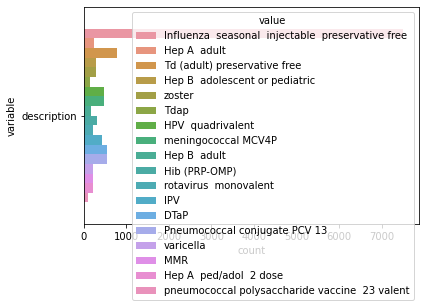

In [140]:
#Grafik Verteilung der Impfungen
sns.countplot(y="variable", hue= "value", data=pd.melt(df_immunization[["description"]]))
plt.savefig(image_path+'Histogramm_Impfungsverteilung.png')
plt.show()

In [120]:
#Übersicht zur zentralen View des Stern-Schemas
#df_enc_star = pd.read_sql_query("SELECT * FROM v_encounters_aggr", conn)
#df_enc_star = pd.read_sql_query("SELECT * FROM tb_patients", conn)

#df_enc_star.info()
#df_enc_star